In [23]:
!pip install fastkaggle
!pip install kaggle

In [73]:
import fastkaggle
import kaggle

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [4]:
comp = 'paddy-disease-classification'
path = fastkaggle.setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [5]:
path

Path('../input/paddy-disease-classification')

In [6]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


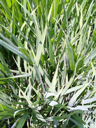

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [9]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

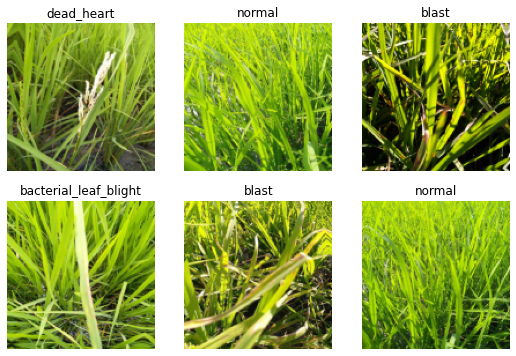

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0006918309954926372, slide=0.0030199517495930195)

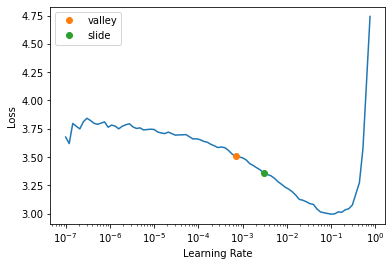

In [13]:
learn.lr_find(suggest_funcs=(valley, slide))

In [14]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.774856,1.150233,0.367131,03:24


epoch,train_loss,valid_loss,error_rate,time
0,1.122452,0.691662,0.226814,02:58
1,0.760924,0.441710,0.142720,02:57
2,0.547671,0.380315,0.122057,02:58


In [15]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [16]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [17]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 1, 5])

In [18]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [19]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [20]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [89]:
#if not iskaggle:
from kaggle import api
api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.

In [125]:
!ls .kaggle/

In [ ]:
if not iskaggle:
    push_notebook('rdkulkarni', 'First attempt with Kaggle and FastAI',
                  title='First attempt with Kaggle and FastAI',
                  file='kaggle-fastai.ipynb',
                  competition=comp, private=True, gpu=True)